In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [2]:
# Load the datasets
train_df = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_Train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_test.csv')
validation_df = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_Validation.csv')

In [3]:
# Function to preprocess datasets
def preprocess_data(df):
    df['local_time'] = pd.to_datetime(df['local_time'])
    for time_unit in ['Year', 'Month', 'Day', 'Hour']:
        df[time_unit] = getattr(df['local_time'].dt, time_unit.lower())
    return df.drop('local_time', axis=1)

In [4]:
def add_cyclical_features(df, col_name, max_val):
    if col_name in df.columns:
        df[col_name + '_sin'] = np.sin(2 * np.pi * df[col_name] / max_val)
        df[col_name + '_cos'] = np.cos(2 * np.pi * df[col_name] / max_val)
    return df

#'Hour', 'Day', and 'Month' created
for df in [train_df, validation_df, test_df]:
    df = add_cyclical_features(df, 'Hour', 23)
    df = add_cyclical_features(df, 'Day', 31)
    df = add_cyclical_features(df, 'Month', 12)

In [5]:
def add_lagged_features(df, feature_cols, n_lags=3):
    for feature in feature_cols:
        for lag in range(1, n_lags + 1):
            df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
    return df.dropna().reset_index(drop=True)

# Preprocess all datasets
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)
validation_df = preprocess_data(validation_df)

# Specifying the features to lag
features_to_lag = ['Average_Temp', 'MW']  # Add other relevant features as needed

# Applying the function to the datasets
train_df = add_lagged_features(train_df, features_to_lag, n_lags=3)
validation_df = add_lagged_features(validation_df, features_to_lag, n_lags=3)
test_df = add_lagged_features(test_df, features_to_lag, n_lags=3)

In [6]:
from sklearn.preprocessing import PolynomialFeatures

# Creating polynomial and interaction features
poly = PolynomialFeatures(degree=2, include_bias=False)

# Applying transformation to all datasets.
train_features = train_df.drop(columns=['MW'])
validation_features = validation_df.drop(columns=['MW'])
test_features = test_df.drop(columns=['MW'])

X_train_poly = poly.fit_transform(train_features)
X_validation_poly = poly.transform(validation_features)
X_test_poly = poly.transform(test_features)


feature_names = poly.get_feature_names_out(input_features=train_features.columns)


y_train = train_df['MW']
y_validation = validation_df['MW']
y_test = test_df['MW']

In [7]:
# Evaluation Function

def calculate_metrics(actual, predicted, lower_bound=0, upper_bound=100, iqr_multiplier=1.5):
    # Excluding negative actual values if considered invalid
    valid_indices = actual > lower_bound
    actual = actual[valid_indices]
    predicted = predicted[valid_indices]

    # Calculate MAE and RMSE
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    # Thresholding for outlier exclusion based on IQR
    q1, q3 = np.percentile(actual, [25, 75])
    iqr = q3 - q1
    outlier_threshold_upper = q3 + (iqr * iqr_multiplier)
    outlier_threshold_lower = q1 - (iqr * iqr_multiplier)

    valid_indices_for_mape = (actual >= outlier_threshold_lower) & (actual <= outlier_threshold_upper)
    filtered_actual = actual[valid_indices_for_mape]
    filtered_predicted = predicted[valid_indices_for_mape]

    # Calculate Modified MAPE with capped at 100%
    if len(filtered_actual) > 0:
        percentage_errors = np.abs((filtered_predicted - filtered_actual) / filtered_actual) * 100
        percentage_errors = np.clip(percentage_errors, None, upper_bound)  # Cap percentage errors at upper_bound (100%)
        mape = np.mean(percentage_errors)
    else:
        mape = np.nan

    # Calculate sMAPE
    smape = 100/len(actual) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

    return mae, mape, smape, rmse

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb

# Adjusted SARIMAX Model Setup to Prevent Overfitting
sarimax_model_adjusted = SARIMAX(y_train,
                                 order=(1, 1, 1),  # Keep it simple; adjust based on your dataset
                                 seasonal_order=(1, 1, 1, 12),  # Adjust as needed
                                 exog=X_train_poly,
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
sarimax_result_adjusted = sarimax_model_adjusted.fit(disp=False)

# SARIMAX Validation Prediction
sarimax_pred_adjusted = sarimax_result_adjusted.forecast(steps=len(y_validation), exog=X_validation_poly)

# Adjusted XGBoost Model Setup to Prevent Overfitting
xgb_model_adjusted = xgb.XGBRegressor(objective='reg:squarederror',
                                      n_estimators=100,  # Consider reducing if overfitting is observed
                                      max_depth=3,  # Reduced to prevent overfitting
                                      learning_rate=0.05,  # Lower learning rate to prevent overfitting
                                      subsample=0.8,  # Use a subset of data to prevent overfitting
                                      reg_lambda=1,  # L2 regularization
                                      reg_alpha=0.5)  # L1 regularization
xgb_model_adjusted.fit(X_train_poly, y_train)

# XGBoost Validation Prediction
xgb_pred_adjusted = xgb_model_adjusted.predict(X_validation_poly)

# Combining SARIMAX and XGBoost predictions based on thresholds
T1 = 71.54
T2 = 156.97
final_predictions_adjusted = np.where(sarimax_pred_adjusted < T1, xgb_pred_adjusted, np.where(sarimax_pred_adjusted < T2, sarimax_pred_adjusted, xgb_pred_adjusted))

# Evaluate Combined Model Predictions
final_mae, final_mape, final_smape, final_rmse = calculate_metrics(y_validation, final_predictions_adjusted)

# Print Evaluation Results for Combined Predictions
print("Combined SARIMAX and XGBoost Evaluation:")
print(f"MAE: {final_mae}, MAPE: {final_mape}, sMAPE: {final_smape}, RMSE: {final_rmse}")


Combined SARIMAX and XGBoost Evaluation:
MAE: 8.029601466721216, MAPE: 14.316205548721141, sMAPE: 14.569438363296733, RMSE: 17.709595879281494


In [ ]:
from joblib import dump

# Save the SARIMAX model
dump(sarimax_result_adjusted, '/content/drive/MyDrive/Saved_trained_models/best_sarimax_model_hybrid.joblib')

# Save the XGBoost model
dump(xgb_model_adjusted, '/content/drive/MyDrive/Saved_trained_models/best_xgb_sarimax_model_hybrid.joblib')


['/content/drive/MyDrive/Saved_trained_models/best_xgb_sarimax_model_hybrid.joblib']

In [8]:
from joblib import load
# Load the best ARIMA model
sarimax_result_adjusted = load('/content/drive/MyDrive/Saved_trained_models/best_sarimax_model_hybrid.joblib')

# Load the best XGBoost model
xgb_model_adjusted = load('/content/drive/MyDrive/Saved_trained_models/best_xgb_sarimax_model_hybrid.joblib')

In [9]:
# SARIMAX Validation Prediction
sarimax_pred_adjusted = sarimax_result_adjusted.forecast(steps=len(y_validation), exog=X_validation_poly)

# XGBoost Validation Prediction
xgb_pred_adjusted = xgb_model_adjusted.predict(X_validation_poly)

# Combining SARIMAX and XGBoost predictions based on thresholds
T1 = 71.54
T2 = 156.97
final_predictions_adjusted = np.where(sarimax_pred_adjusted < T1, xgb_pred_adjusted, np.where(sarimax_pred_adjusted < T2, sarimax_pred_adjusted, xgb_pred_adjusted))

# Evaluate Combined Model Predictions
final_mae, final_mape, final_smape, final_rmse = calculate_metrics(y_validation, final_predictions_adjusted)

# Print Evaluation Results for Combined Predictions
print("Combined SARIMAX and XGBoost Evaluation:")
print(f"MAE: {final_mae}, MAPE: {final_mape}, sMAPE: {final_smape}, RMSE: {final_rmse}")

Combined SARIMAX and XGBoost Evaluation:
MAE: 8.029601466721216, MAPE: 14.316205548721141, sMAPE: 14.569438363296733, RMSE: 17.709595879281494


In [10]:
# SARIMAX Validation Prediction
sarimax_pred_adjusted = sarimax_result_adjusted.forecast(steps=len(y_test), exog=X_test_poly)

# XGBoost Validation Prediction
xgb_pred_adjusted = xgb_model_adjusted.predict(X_test_poly)

# Combining SARIMAX and XGBoost predictions based on thresholds
T1 = 71.54
T2 = 156.97
final_predictions_adjusted = np.where(sarimax_pred_adjusted < T1, xgb_pred_adjusted, np.where(sarimax_pred_adjusted < T2, sarimax_pred_adjusted, xgb_pred_adjusted))

# Evaluate Combined Model Predictions
final_mae, final_mape, final_smape, final_rmse = calculate_metrics(y_test, final_predictions_adjusted)
test_metrics = [final_mae, final_mape, final_smape, final_rmse]

# Print Evaluation Results for Combined Predictions
print("Combined SARIMAX and XGBoost Evaluation:")
print(f"MAE: {final_mae}, MAPE: {final_mape}, sMAPE: {final_smape}, RMSE: {final_rmse}")

Combined SARIMAX and XGBoost Evaluation:
MAE: 5.329209935942921, MAPE: 6.597304105285113, sMAPE: 8.386579647421343, RMSE: 12.563463461673702


In [ ]:
len(y_validation)

8758

In [ ]:
len(y_test)

1437

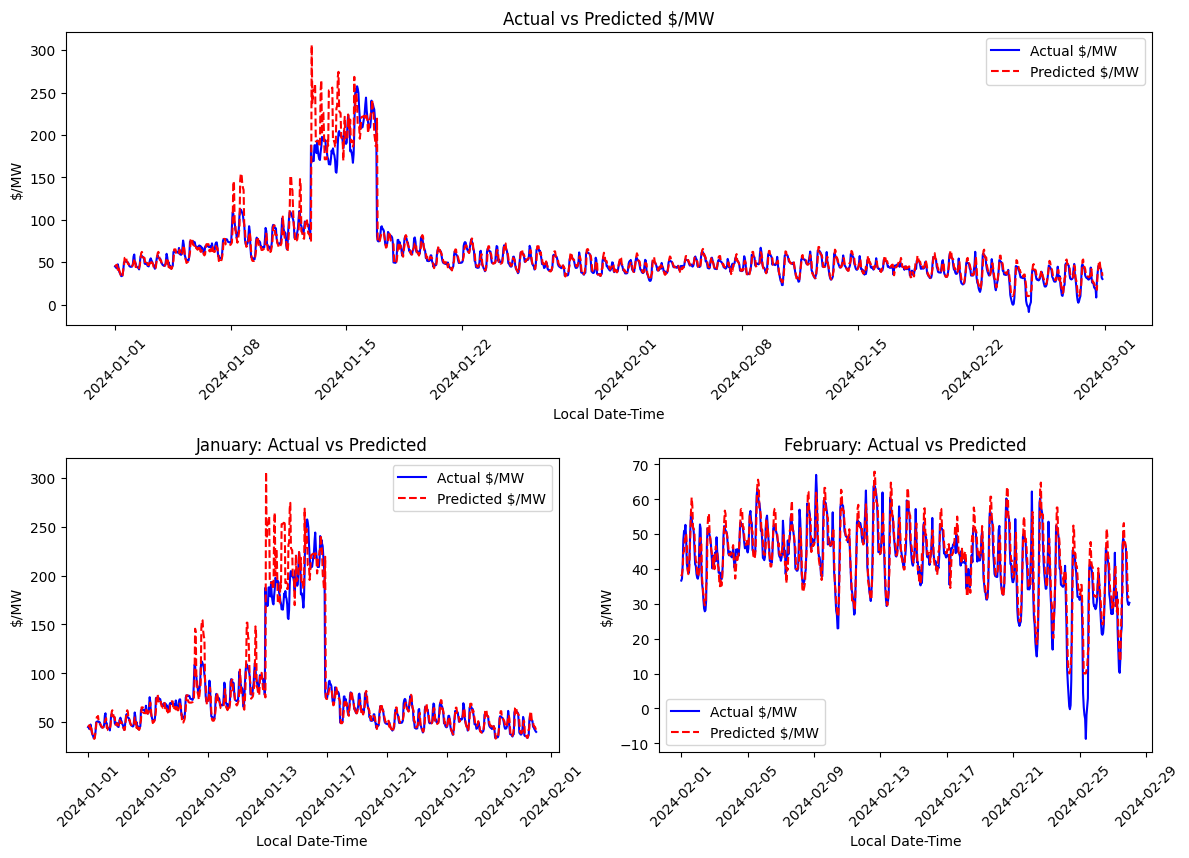

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

test_df_for_plotting = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_test.csv', usecols=['local_time'])
test_local_time = pd.to_datetime(test_df_for_plotting['local_time'])

if len(test_local_time) > len(final_predictions_adjusted):
    test_local_time = test_local_time[:len(final_predictions_adjusted)]

test_local_time = pd.to_datetime(test_local_time)

january_start = "2024-01-01"
january_end = "2024-01-31"
is_january = (test_local_time >= january_start) & (test_local_time <= january_end)
january_indices = np.where(is_january)[0]

january_times = test_local_time[january_indices]
january_actual = y_test[january_indices]
january_predictions = final_predictions_adjusted[january_indices]

february_start = "2024-02-01"
february_end = "2024-02-28"
is_february = (test_local_time >= february_start) & (test_local_time <= february_end)
february_indices = np.where(is_february)[0]

february_times = test_local_time[february_indices]
february_actual = y_test[february_indices]
february_predictions = final_predictions_adjusted[february_indices]

# Check lengths before plotting to avoid ValueError
if len(test_local_time) == len(y_test) == len(final_predictions_adjusted):
    plt.figure(figsize=(12, 12))
    gs = gridspec.GridSpec(3, 2)

    ax0 = plt.subplot(gs[0, :])
    ax0.plot(test_local_time, y_test, label='Actual $/MW', color='blue')
    ax0.plot(test_local_time, final_predictions_adjusted, label='Predicted $/MW', color='red', linestyle='--')
    ax0.set_title('Actual vs Predicted $/MW')
    ax0.set_xlabel('Local Date-Time')
    ax0.set_ylabel('$/MW')
    ax0.legend()
    ax0.tick_params(axis='x', rotation=45)

    # Plotting January and February assuming 'january_times', 'february_times', and corresponding actuals and predictions are correctly aligned
    ax1 = plt.subplot(gs[1, 0])
    ax1.plot(january_times, january_actual, label='Actual $/MW', color='blue')
    ax1.plot(january_times, january_predictions, label='Predicted $/MW', color='red', linestyle='--')
    ax1.set_title('January: Actual vs Predicted')
    ax1.set_xlabel('Local Date-Time')
    ax1.set_ylabel('$/MW')
    ax1.legend()
    ax1.tick_params(axis='x', rotation=45)

    ax2 = plt.subplot(gs[1, 1])
    ax2.plot(february_times, february_actual, label='Actual $/MW', color='blue')
    ax2.plot(february_times, february_predictions, label='Predicted $/MW', color='red', linestyle='--')
    ax2.set_title('February: Actual vs Predicted')
    ax2.set_xlabel('Local Date-Time')
    ax2.set_ylabel('$/MW')
    ax2.legend()
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()
else:
    print("Mismatch in lengths of time and value arrays. Please check and align them before plotting.")

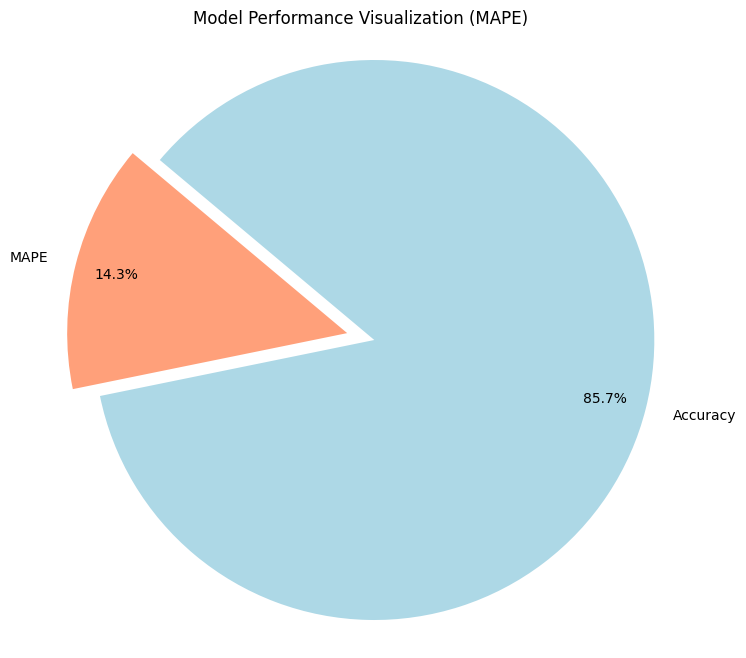

In [ ]:
import matplotlib.pyplot as plt

# Assuming test_metrics is structured as [MAE, MAPE, sMAPE, RMSE]
mape = test_metrics[1]
accuracy = 100 - mape  # Calculating accuracy as the complement of MAPE

# Data for plotting
labels = ['MAPE', 'Accuracy']
sizes = [mape, accuracy]
colors = ['#FFA07A', '#ADD8E6']
explode = (0.1, 0)  # Only explode the MAPE slice

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, pctdistance=0.85)
plt.axis('equal')
plt.title('Model Performance Visualization (MAPE)')
plt.show()

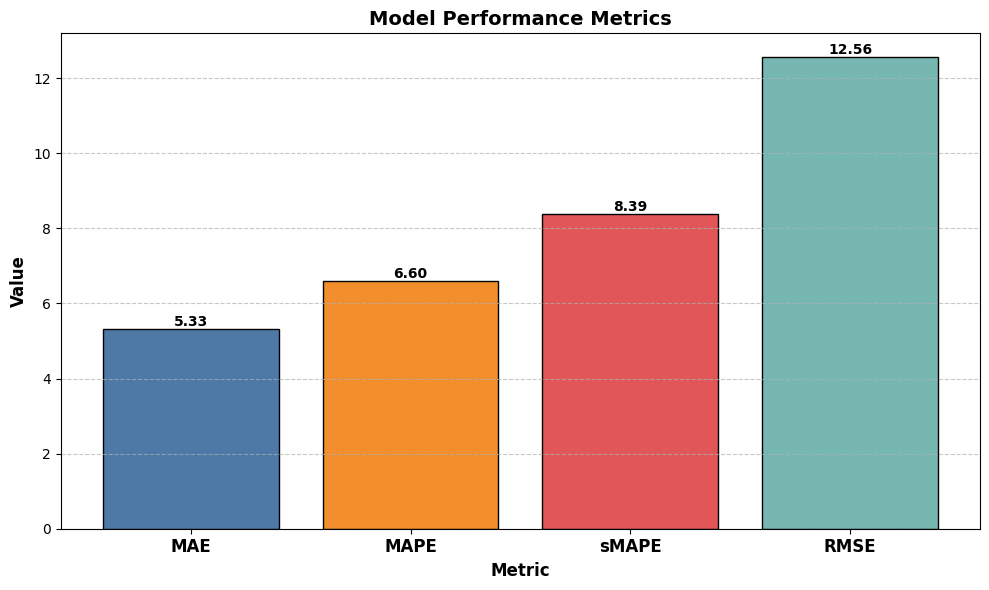

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Metric names
metrics_names = ['MAE', 'MAPE', 'sMAPE', 'RMSE']

# Creating an array with the positions of the bars along the x-axis
x_pos = np.arange(len(metrics_names))

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(x_pos, test_metrics, color=['#4E79A7', '#F28E2B', '#E15759', '#76B7B2'], edgecolor='black')

# Adding the metric names as labels on the x-axis
plt.xticks(x_pos, metrics_names, fontsize=12, fontweight='bold')

# Adding a title and labels for the axes
plt.title('Model Performance Metrics', fontsize=14, fontweight='bold')
plt.xlabel('Metric', fontsize=12, fontweight='bold')
plt.ylabel('Value', fontsize=12, fontweight='bold')

# Optional: Adding the value of each metric above its bar for clarity
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Adding gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

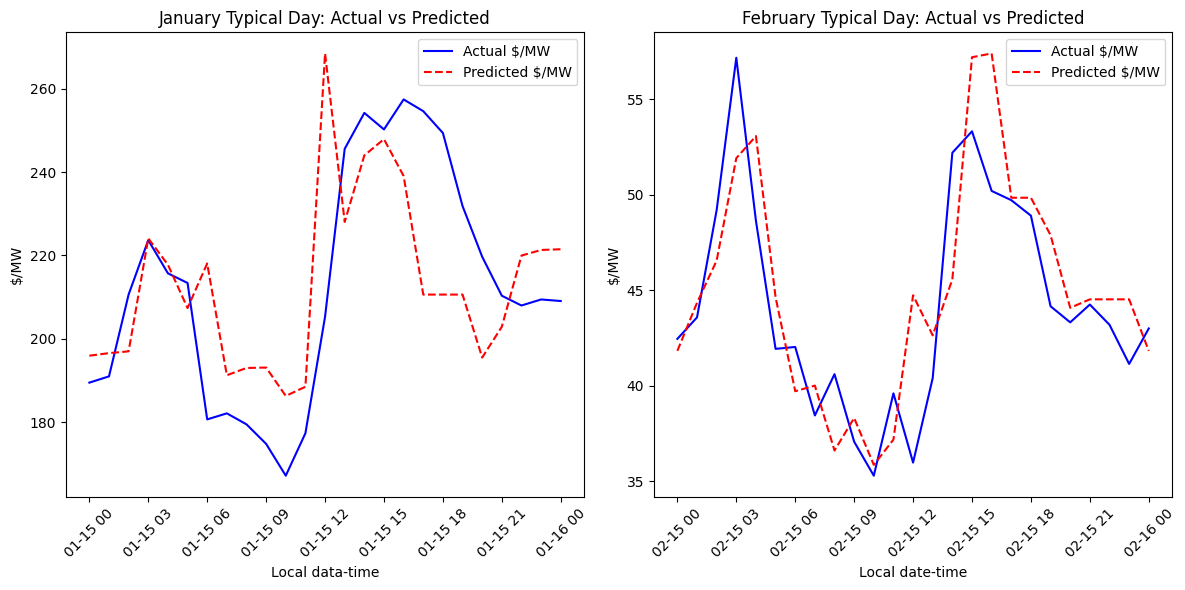

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Convert 'test_local_time' to datetime if it's not already
test_local_time = pd.to_datetime(test_local_time)

# Filter for January
january_start = "2024-01-15"
january_end = "2024-01-16"
is_january = (test_local_time >= january_start) & (test_local_time <= january_end)
january_times = test_local_time[is_january]
january_actual = y_test[is_january]
january_predictions = final_predictions_adjusted[is_january]

# Filter for February
february_start = "2024-02-15"
february_end = "2024-02-16"
is_february = (test_local_time >= february_start) & (test_local_time <= february_end)
february_times = test_local_time[is_february]
february_actual = y_test[is_february]
february_predictions = final_predictions_adjusted[is_february]

# Set up the plot layout
plt.figure(figsize=(12, 6))  # Adjusted for a wider aspect to accommodate two columns
gs = gridspec.GridSpec(1, 2)  # Adjusted to define a grid of 1 row and 2 columns

# January subplot in the first row, first column
ax1 = plt.subplot(gs[0, 0])  # Top left
ax1.plot(january_times, january_actual, label='Actual $/MW', color='blue')
ax1.plot(january_times, january_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax1.set_title('January Typical Day: Actual vs Predicted')
ax1.set_xlabel('Local data-time')
ax1.set_ylabel('$/MW')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()

# February subplot in the first row, second column
ax2 = plt.subplot(gs[0, 1])  # Top right
ax2.plot(february_times, february_actual, label='Actual $/MW', color='blue')
ax2.plot(february_times, february_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax2.set_title('February Typical Day: Actual vs Predicted')
ax2.set_xlabel('Local date-time')
ax2.set_ylabel('$/MW')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

plt.tight_layout()  # Adjust layout to make room for all elements
plt.show()
